**Loading the dataset**


In [2]:
import pandas as pd
import random

# List of public holidays
public_holidays = {
    # 2023 Holidays
    '2023-01-01': 'New Year’s Day',
    '2023-02-20': 'Family Day',  # Example: South Africa
    '2023-03-21': 'Human Rights Day',  # Example: South Africa
    '2023-04-07': 'Good Friday',
    '2023-04-10': 'Easter Monday',
    '2023-04-27': 'Freedom Day',  # Example: South Africa
    '2023-05-01': 'Workers\' Day',
    '2023-06-16': 'Youth Day',  # Example: South Africa
    '2023-08-09': 'Women’s Day',  # Example: South Africa
    '2023-09-24': 'Heritage Day',  # Example: South Africa
    '2023-12-25': 'Christmas',
    '2023-12-26': 'Boxing Day',

    # 2024 Holidays
    '2024-01-01': 'New Year’s Day',
    '2024-02-19': 'Family Day',  # Example: South Africa
    '2024-03-21': 'Human Rights Day',  # Example: South Africa
    '2024-03-29': 'Good Friday',
    '2024-04-01': 'Easter Monday',
    '2024-04-27': 'Freedom Day',  # Example: South Africa
    '2024-05-01': 'Workers\' Day',
    '2024-06-16': 'Youth Day',  # Example: South Africa
    '2024-08-09': 'Women’s Day',  # Example: South Africa
    '2024-09-24': 'Heritage Day',  # Example: South Africa
    '2024-12-25': 'Christmas',
    '2024-12-26': 'Boxing Day',
    '2024-12-31': 'New Year’s Eve',
}

def generate_data(start_date, end_date):
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    data = []

    products = ['Milk', 'Bread', 'Eggs', 'Butter', 'Sugar', 'Rice', 'Tea', 'Coffee']
    seasons = ['Winter', 'Spring', 'Summer', 'Fall']
    event_types = ['Community Fest', 'Festival']
    weather_conditions = ['Cold', 'Mild', 'Warm']

    for date in dates:
        for product in products:  # Record data for all products each day
            day_of_week = date.strftime('%A')
            quantity_sold = random.randint(10, 100)  # Number of units sold
            price = random.uniform(1.0, 10.0)  # Price per unit (random float between 1.0 and 10.0)
            sales = quantity_sold * price  # Total sales for the product
            inventory_level = random.randint(50, 150)  # Inventory level for the product
            season = seasons[(date.month - 1) // 3]  # Simplified season determination
            local_event = random.choice([True, False])  # Randomly determine if a local event happened
            event_type = random.choice(event_types) if local_event else 'N/A'  # Assign proper event type if event occurs
            sales_category = 'Essentials' if product in ['Milk', 'Bread', 'Eggs', 'Butter'] else 'Non-Essentials'
            sales_promotion = random.choice([True, False])
            weather = random.choice(weather_conditions)
            holiday = public_holidays.get(date.strftime('%Y-%m-%d'), 'No Holiday')

            data.append([date, day_of_week, quantity_sold, sales, inventory_level, product, season, local_event, event_type,
                sales_category, sales_promotion, weather, holiday
            ])

    df = pd.DataFrame(data, columns=[
        'Date', 'Day of Week', 'Quantity_Sold', 'Sales', 'Inventory_Level', 'Product', 'Season',
        'Local_Event', 'Event_Type', 'Sales_Category', 'Sales_Promotion', 'Weather', 'Holiday'
    ])

    return df

# Generate data
df = generate_data('2023-01-01', '2024-12-31')


Before feeding data to an LSTM model, the data needs to be scaled (normalized) because LSTMs are sensitive to input ranges. We also need to select only the relevant features like Sales, Quantity_Sold, and Inventory_Level.

What this does:
MinMaxScaler scales the values of Sales, Quantity_Sold, and Inventory_Level to a range between 0 and 1.
df_scaled contains the normalized values, which will be used as input for the LSTM model.

In [3]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Preprocess data by scaling numerical features
def preprocess_data(df):
    # Scale numerical features: Sales, Quantity_Sold, and Inventory_Level
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled = scaler.fit_transform(df[['Sales', 'Quantity_Sold', 'Inventory_Level']])

    return df_scaled, scaler

# Generate dataset
df = generate_data('2023-01-01', '2024-12-31')

# Select relevant features and preprocess
df_selected = df[['Sales', 'Quantity_Sold', 'Inventory_Level']]
df_scaled, scaler = preprocess_data(df_selected)

print("Scaled data:\n", df_scaled[:5])  # Display the first 5 rows of scaled data


Scaled data:
 [[0.23921333 0.2        0.61      ]
 [0.06909887 0.08888889 0.73      ]
 [0.60751708 0.57777778 0.89      ]
 [0.69749736 0.96666667 0.84      ]
 [0.59355304 0.64444444 0.97      ]]


**2. Creating Sequences for LSTM**

Explanation:
LSTM models require sequential data, so we need to create sequences where each sequence consists of data from a specific number of previous days (e.g., 30 days) to predict the next day's sales.

Code:

What this does:
create_sequences creates input-output pairs for the LSTM model.
X: Contains sequences of past 30 days (or specified time window).
y: Contains the sales for the next day (prediction target).
Example:

If X contains data for days 1 to 30, y will be the sales for day 31.

In [4]:
import numpy as np

# Create sequences for LSTM
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :])  # Past 'time_steps' data points as input
        y.append(data[i + time_steps, 0])    # Predict 'Sales' (column 0) for the next day
    return np.array(X), np.array(y)

# Create sequences for 30-day periods
time_steps = 30
X, y = create_sequences(df_scaled, time_steps)

print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (5818, 30, 3), y shape: (5818,)


**3. Train-Test Split**

Explanation:
We need to split the data into training and testing sets. The training set is used to train the LSTM model, while the testing set is used to evaluate its performance.

What this does:
Train-Test Split: The code splits the sequences into 80% training data and 20% testing data to ensure we evaluate the model on unseen data.

In [5]:
# Split data into training and testing sets
split = int(0.8 * len(X))  # Use 80% of the data for training
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training data shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing data shape: X_test: {X_test.shape}, y_test: {y_test.shape}")


Training data shape: X_train: (4654, 30, 3), y_train: (4654,)
Testing data shape: X_test: (1164, 30, 3), y_test: (1164,)


**4. Building the LSTM Model**
Explanation:
We will create the LSTM model using TensorFlow/Keras. The model consists of:

Two LSTM layers with 50 neurons each.
Dropout layers to reduce overfitting.
A Dense layer to predict the output (sales).

What this does:
LSTM Layer: The LSTM layer learns sequential dependencies from the data.
units=50 specifies the number of neurons.
return_sequences=True allows the next LSTM layer to receive sequences as input.
Dropout: Helps reduce overfitting by randomly setting some of the neurons to 0 during training.
Dense Layer: Outputs the predicted sales value.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build LSTM model
model = Sequential()

# First LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, X.shape[2])))
model.add(Dropout(0.2))  # Dropout to prevent overfitting

# Second LSTM layer
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1))  # Predicting 'Sales'

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 50)              │          10,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,051 (121.29 KB)

 Trainable params: 31,051 (121.29 KB)

 Non-trainable params: 0 (0.00 B)

**5. Training the Model**
Explanation:
Now that the model is built, we can train it using the training data. We'll also monitor its performance on the test data during training using the validation_data parameter.

Code:

What this does:
Training: The model is trained for 20 epochs with a batch size of 32.
Epoch: A complete pass through the training dataset.
Batch size: The number of samples processed before the model updates its weights.
Plot: We plot the training and validation loss to monitor how well the model fits the data.

Epoch 1/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - loss: 0.0527 - val_loss: 0.0494
Epoch 2/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0498 - val_loss: 0.0476
Epoch 3/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 0.0500 - val_loss: 0.0476
Epoch 4/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0475 - val_loss: 0.0490
Epoch 5/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0494 - val_loss: 0.0477
Epoch 6/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 0.0510 - val_loss: 0.0480
Epoch 7/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 0.0498 - val_loss: 0.0479
Epoch 8/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - loss: 0.0493 - val_loss: 0.0477
Epoch 9/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0490 - val_loss: 0.0480
Epoch 10/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0502 - val_loss: 0.0478
Epoch 11/20
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0486 - val_loss: 0.0478
Epoch 12/20
146/146 ━━━━━━━━━━━━━━━━━━━━

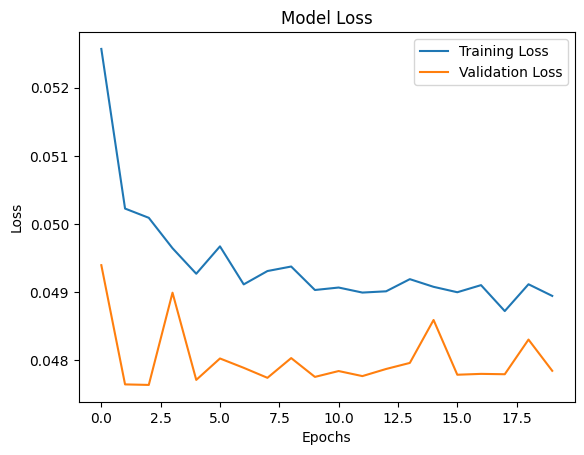

In [7]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Plot training & validation loss over epochs
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


**6. Evaluating the Model**
Explanation:
After training, we evaluate the model on the test data. We use RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error) to measure the model’s performance.

Code:

What this does:
Predictions: The model predicts sales on the test set.
Inverse Transform: We use the scaler to inverse-transform the predictions and the actual sales values back to their original scale.
Performance Metrics:
RMSE: Measures the square root of the average squared differences between predicted and actual values.
MAE: Measures the average absolute differences between predicted and actual values.


In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform the predicted values back to original scale
y_test_scaled = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 2)))))
y_pred_scaled = scaler.inverse_transform(np.hstack((y_pred, np.zeros((y_pred.shape[0], 2)))))

# Compute RMSE and MAE
rmse = sqrt(mean_squared_error(y_test_scaled[:, 0], y_pred_scaled[:, 0]))
mae = mean_absolute_error(y_test_scaled[:, 0], y_pred_scaled[:, 0])

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
RMSE: 215.69870493355896
MAE: 179.29512156659075


**Step 7**
We can plot the actual vs. predicted sales to see how well the model is performing.
What this does:
Visualization: It generates a line plot that compares the actual and predicted sales over time.



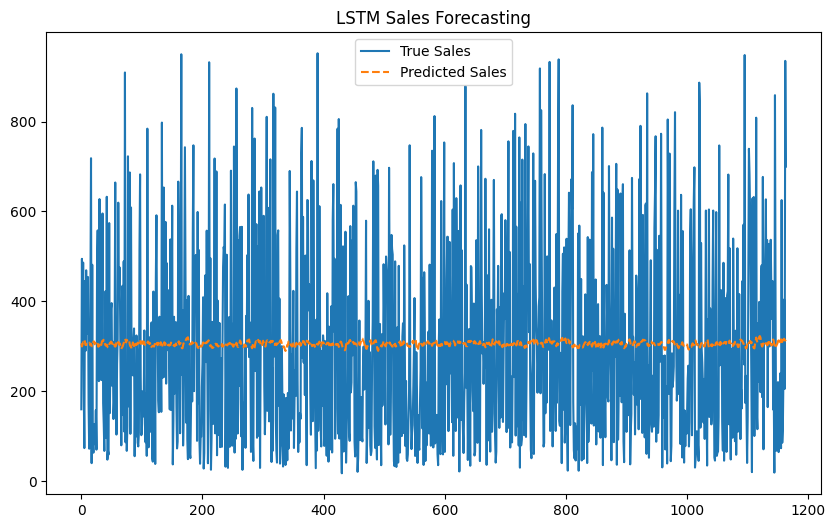

In [9]:
# Plot true vs predicted sales
plt.figure(figsize=(10, 6))
plt.plot(y_test_scaled[:, 0], label='True Sales')
plt.plot(y_pred_scaled[:, 0], label='Predicted Sales', linestyle='--')
plt.legend()
plt.title('LSTM Sales Forecasting')
plt.show()



Based on the sales forecasting model results and the analysis of the dataset, here are some actionable recommendations for the shop owner to improve sales and optimize other aspects of their business:

**1. Optimize Inventory Management:**

Stock Levels: Ensure that inventory levels are aligned with sales predictions. The model can help identify peak sales periods, so adjust stock levels accordingly to avoid stockouts or overstocking.
Inventory Turnover: Analyze the inventory levels in relation to sales and adjust procurement strategies to ensure a balance between supply and demand.

**2. Enhance Marketing Strategies:**

Sales Promotions: Utilize the insights from the Sales_Promotion data to determine which promotions are most effective. Run targeted promotions during identified peak periods to boost sales.
Local Events: Leverage local events and community festivals (Local_Event and Event_Type). Plan marketing campaigns around these events to increase foot traffic and sales.

**3. Adjust Product Pricing:**

Pricing Strategy: Review the pricing data to determine if any adjustments are necessary. Competitive pricing can help increase sales, especially for high-demand products.
Price Sensitivity: Analyze how price changes affect sales. Consider running experiments to understand price elasticity and optimize pricing strategies.